In [3]:
from header import*
#import seaborn as sns

plt.rcParams.update({'font.size': 14})

In [4]:
def astar_vs_dijkstra_img(df, x, y, hline, prefix, algo1=None, algo2=None, show_mean=False, trend_line=True, ylog=True):
    #fig, ax = plt.subplots()
    fig, ax = plt.subplots(1, 1)
    fig.set_size_inches(6, 4, forward=True)
    
    # grid
    ax.set_facecolor('#F3F3F3')
    
    # ticks
    ax.tick_params(
        axis='both',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom=True,      # ticks along the bottom edge are off
        top=False,         # ticks along the top edge are off
    #    labelbottom=False # labels along the bottom edge are off
        labelsize=16,
    )
    
    #ax.tick_params(
    #    axis='y',          # changes apply to the x-axis
    #    which='minor',      # both major and minor ticks are affected
    #    left=False,         # ticks along the top edge are off
    #    labelbottom=False # labels along the bottom edge are off
    #)
    
    # spines
    for spine in ["top", "left", "right"]:
        ax.spines[spine].set_visible(False)
    
    # Data
    d = df.groupby(['algo', x], group_keys=False, observed=True)[y].mean()  # observed=True drops categorical algos that don't appear
    d = d.reset_index(name='mean_{}'.format(y))
    d = d.pivot(index=x, columns='algo', values='mean_{}'.format(y))
   
    if trend_line:
        z = {}
        for algo in d.columns:
            s = d[algo].dropna()
            z[algo] = np.polyfit(s.index, np.log(s), 1)
            #display(s, z[algo])
        xs = list(d.index)
        if show_mean:
            d = d.append(df.groupby('algo')[y].mean().rename('all'))
        #xs.append(xs[-1]*1.1)  # extrapolation
        
        # ln(y[i]) ~= a*x[i] + b
        #  => y[i] ~= exp(a*x[i] + b)
        # y[i] = O(base^i) = C * base^i
        #  => a*x[i] + b = ln(C * base^x[i]) = ln(base)*x[i] + ln(C)
        #  => a*x[0] + b = ln(base)*x[0] + ln(C)
        #     a*x[1] + b = ln(base)*x[1] + ln(C)
        #  => a*(x[1]-x[0]) = ln(base)*(x[1]-x[0]) => base = exp(a)
        
        # Best fit lines
        for algo in d.columns:
            regression_line = []
            a, b = z[algo]
            #angle = math.atan2(a, abs(b)) * 180 / math.pi
            for i in xs:
                regression_line.append(np.exp(a*i+b))
            #display(regression_line)
            ax.plot(xs, regression_line, linestyle='-', color=algo2color(algo), alpha=0.8)
            label = '${{{:0.2f}}}^x$'.format(np.exp(a*(s.index[1]-s.index[0])))
            ax.text(xs[-1], regression_line[-1], label, #rotation=angle,
                    color=algo2color(algo), ha='center', va='bottom', size=16, alpha=1)
    
    # ticks
    if x == 'error_rate':
        ax.xaxis.set_major_formatter(ticker.PercentFormatter(xmax=1.0, decimals=0))
    
    if x == 'cost':
        ax.set_xticks(np.arange(0, max(df[x])+1, 1))
    
    #arr = [ 0 ] + [ 10**n for n in range(0,int(math.log10(max(df[y])))+1) ]
    #ax.set_yticks(arr)

    # Times
    #for index, row in d.iterrows():
        #print(row["astar-seeds"])
        #print(row["astar-seeds-intervals"])
    #    label = '{0:.3g}x'.format(row[algo1] / row[algo2])
    #    tmp_x = index if index != 'all' else len(d)-1
    #    tmp_y = np.exp((np.log(row[0]) + np.log(row[1])) / 2)
    #    ax.text(tmp_x, tmp_y, label, ha='right', va='center', size=12, alpha=0.7)
        
    colors = [ algo2color(algo) for algo in d.columns ]
    d.columns = [ algo2beautiful(col) for col in d.columns ]
    
    ########### Bars
    d.plot(ax=ax, alpha=0.6, zorder=3, rot=0, color=colors, marker='o', ls='')
    #d.plot.bar(ax=ax, alpha=0.5, width=0.7, zorder=3, rot=0, color=colors)
    
    if hline:
        ax.legend(loc="upper left", bbox_to_anchor=(0.0, 0.95), prop={'size': 15}, framealpha=0.5)
    else:
        ax.legend(loc="upper left", prop={'size': 15}, framealpha=0.5)

    if hline:
        if y == 'explored_states' or y == 'crumbs':
            miny = df.len.median()
            maxy = df.refsize.median()*df.len.median()
        elif y == 'explored_per_bp':
            miny = 1
            maxy = df.refsize.median()
        else:
            assert(False)
        
        ax.axhline(maxy, color='k', linestyle='--', label=df.ref[0]) #, xmin=min(df[x]), xmax=max(df[x])+1
        ax.text(0.0, maxy, 'max    ', ha='right', va='center', size=16)
        
        ax.axhline(y=miny, color='k', linestyle='--', label=df.ref[0])  # xmin=min(df[x]), xmax=max(df[x])+1, 
        ax.text(0.0, miny, 'min    ', ha='right', va='center', size=16)

    if ylog:
        ax.set_yscale('log')
       
    #ax.grid(True, which='both', axis='y', color='w')
    #ax.grid(False, axis='x', which='both')
    ax.grid(True, axis='y', which='major', color='w')
    ax.grid(False, axis='y', which='minor')
    
    # axis labels
    ax.set_xlabel(col2name(x), size=18)  # weight='bold',
    ax.set_ylabel(col2name(y), rotation=0, ha='left', size=18)
    ax.yaxis.set_label_coords(-0.10,1.00)
    
    if y == 't(map)':
        ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda num, pos: myticks(num, pos)+'s'))
    
    #plt.savefig(prefix+'_'+x+'-'+y+'.pdf', bbox_inches='tight')
    plt.savefig(plots_dir/(prefix+'_'+x+'-'+y+'.pdf'), bbox_inches='tight')

/home/pesho/.local/lib/python3.6/site-packages/pandas/core/series.py:679: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/pesho/.local/lib/python3.6/site-packages/ipykernel_launcher.py:114: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


crumbs_per_bp


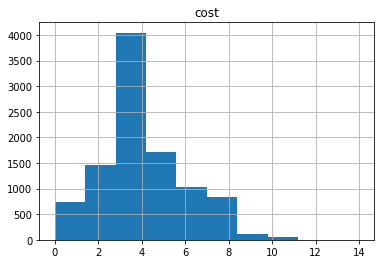

posx and posy should be finite values
posx and posy should be finite values


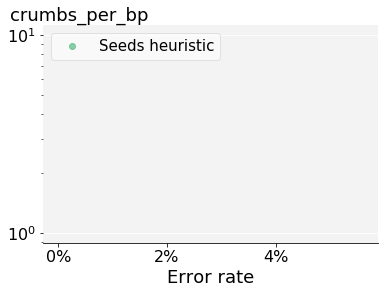

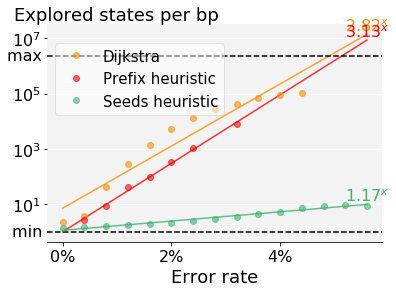

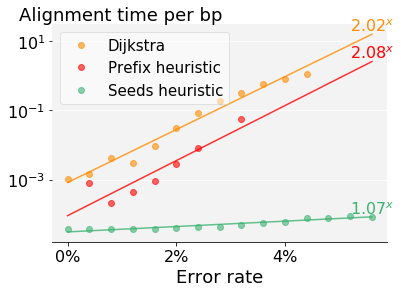

In [25]:
experiment_name = 'prefix_vs_seeds_ecoli_250_errors_intervals_cmp'
plots_dir = Path('plots')

df_seeds = read_astarix_performance('../tmp/ecoli_head1000000_linear_eval250/astar-seeds/alignments.tsv')

df = read_astarix_performance('../tmp/ecoli_head1000000_linear_eval250/astar-prefix/alignments.tsv')
df = df.append(df_seeds, ignore_index=True)
df = df.append(read_astarix_performance('../tmp/ecoli_head1000000_linear_eval250/dijkstra/alignments.tsv'), ignore_index=True)

#display(df_seeds.head())
#display(df.tail())
df_seeds.hist(column='cost')

astar_vs_dijkstra_img(df_seeds, y='crumbs_per_bp', x='error_rate', hline=False, prefix=experiment_name)

# alignment cost
#astar_vs_dijkstra_img(df[df['cost']<=8], y='explored_per_bp', x='cost', hline=True, prefix=experiment_name)

#astar_vs_dijkstra_img(df[df['cost']<=8], y='explored_per_bp', x='cost', hline=True, prefix=experiment_name)
#astar_vs_dijkstra_img(df[df['cost']<=8], y='t(map)_per_bp', x='cost', hline=False, prefix=experiment_name)

# error rate
astar_vs_dijkstra_img(df,  y='explored_per_bp', x='error_rate', hline=True, prefix=experiment_name)
astar_vs_dijkstra_img(df, y='t(map)_per_bp', x='error_rate', hline=False, prefix=experiment_name)

,ref,refsize,algo,operation,memory,len,read,spell,cost,start,strand,pushed,popped,repeat_rate,t(map),t(astar),unique_best,explored_states,crumbs,pushed+popped,explored_per_bp,t(map)_per_bp,crumbs_per_bp,error_rate
readname,,,,,,,,,,,,,,,,,,,,,,,,
all-10000,data/ecoli_head1000000_linear/graph.gfa,2298530,astar-seeds,align,0.0,250,TACTAATCACAAAGTATTATGATACGGCAGTATGCTCGAACGCAGC...,tACtAATCACAAAGTaTTaTGATACGGCAGtATGcTCGAACGCAGC...,6,54749,+,6.508,0.816,0.0,0.011054,0.001336,1,1862,0,7.324,7.448,0.000044,0.0,0.024
all-9999,data/ecoli_head1000000_linear/graph.gfa,2298530,astar-seeds,align,0.0,250,CGCTGCTGTATCCGCTGGCGGAAGATGAGTTGATGAGCATCATTCT...,CGCTGCTgTATCCGCTGGCGGAAGAtGAGTTGATGAGCATCATTCT...,2,533486,+,2.360,0.256,0.0,0.004033,0.000446,1,828,0,2.616,3.312,0.000016,0.0,0.008
all-9998,data/ecoli_head1000000_linear/graph.gfa,2298530,astar-seeds,align,0.0,250,GCTTCGCTTTGCCGTTAATAACATAGCTTGCAGTGGTCCGCGACAC...,GCTTCGCTTTGCCGTTAATAACATAGCTTGCAGTGGTCCGCGACAC...,1,87857,-,0.952,0.104,0.0,0.002029,0.000190,1,476,0,1.056,1.904,0.000008,0.0,0.004
all-9997,data/ecoli_head1000000_linear/graph.gfa,2298530,astar-seeds,align,0.0,250,TTATACCCAAGAGGGGTTAATGTTTGCCTCGATCGTTCAGGAAGGG...,TTATACCCAAGAgGGgtTAaTGtTTGCCTCGAtCGTTCAGGAAGGG...,6,474118,-,5.064,0.660,0.0,0.010097,0.001308,1,1499,0,5.724,5.996,0.000040,0.0,0.024
all-9996,data/ecoli_head1000000_linear/graph.gfa,2298530,astar-seeds,align,0.0,250,TCCTAATTCACTTTCAGCAGGATTTTGCTGAACTCTTCAGTAGAGG...,TCCTaATTCACTTTCAGCAGGATTTTGCtGAACTCTTCAGTAGAGG...,2,483637,+,2.148,0.244,0.0,0.005249,0.000649,1,775,0,2.392,3.100,0.000021,0.0,0.008


/home/pesho/.local/lib/python3.6/site-packages/pandas/core/series.py:679: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/pesho/.local/lib/python3.6/site-packages/ipykernel_launcher.py:114: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


crumbs_per_bp


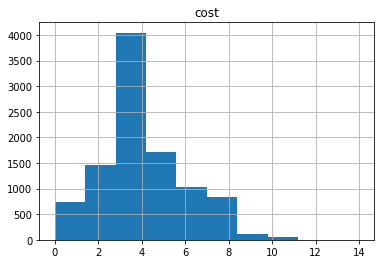

posx and posy should be finite values
posx and posy should be finite values


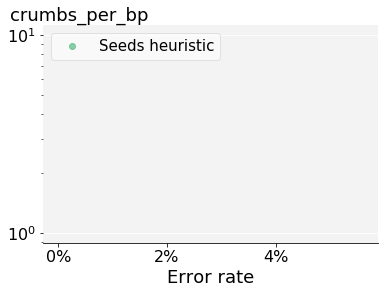

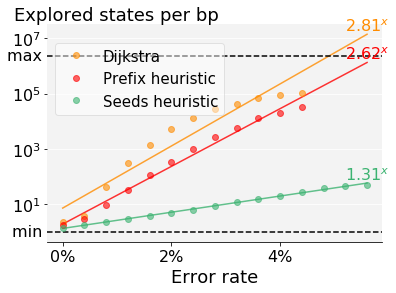

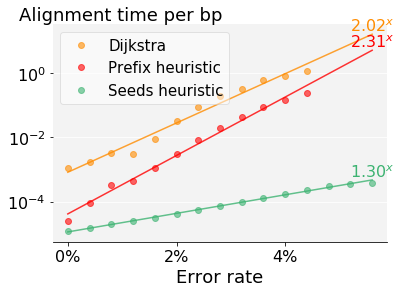

In [23]:
experiment_name = 'test'
plots_dir = Path('plots')

df_seeds = read_astarix_performance('../tmp/ecoli_head1000000_linear_eval250/astar-seeds/alignments.tsv')

display(df_seeds.head())
#display(df.tail())
df_seeds.hist(column='cost')

astar_vs_dijkstra_img(df_seeds, y='crumbs_per_bp', x='error_rate', hline=False, prefix=experiment_name)

# error rate
astar_vs_dijkstra_img(df,  y='explored_per_bp', x='error_rate', hline=True, prefix=experiment_name)
astar_vs_dijkstra_img(df, y='t(map)_per_bp', x='error_rate', hline=False, prefix=experiment_name)

In [24]:
experiment_name = 'MHC'
plots_dir = Path('plots')
df = read_astarix_performance('results/MHC1-astarix-prefix/alignments.tsv')
#df = df.append(read_astarix_performance('results/MHC1-astarix-seeds/alignments.tsv'), ignore_index=True)
df = df.append(read_astarix_performance('results/MHC1-astarix-seeds-bfs/alignments.tsv'), ignore_index=True)

#df = read_astarix_performance('results/ecoli_illumina250_astar-seeds.tsv')
#df = df.append(read_astarix_performance('results/ecoli_illumina250_astar-prefix.tsv'), ignore_index=True)

#df.algo = df.algo.replace(regex=r'astar.*', value='astar')
reads = len(df)
df = df[df.cost <= 8.0]

#display(df.groupby('algo').mean())
display(df.head())
#display(df.groupby('cost').size() / reads)

KeyError: 'explored_states'

In [5]:
def draw_one(df, x, y, hline, prefix, is_log=True, show_mean=True):
    #fig, ax = plt.subplots()
    fig, ax = plt.subplots(1, 1)
    fig.set_size_inches(6, 4, forward=True)
    
    # grid
    ax.set_facecolor('#F0F0F0')
    
    # ticks
    ax.tick_params(
        axis='both',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom=False,      # ticks along the bottom edge are off
        top=False,         # ticks along the top edge are off
    #    labelbottom=False # labels along the bottom edge are off
        labelsize=16,
    )
    
    #ax.tick_params(
    #    axis='y',          # changes apply to the x-axis
    #    which='minor',      # both major and minor ticks are affected
    #    left=False,         # ticks along the top edge are off
    #    labelbottom=False # labels along the bottom edge are off
    #)
    
    # spines
    for spine in ["top", "left", "right"]:
        ax.spines[spine].set_visible(False)
    
    # Data
    d = df.groupby(['algo', x], group_keys=False)[y].mean()
    d = d.reset_index(name='mean_{}'.format(y))
    d = d.pivot(index=x, columns='algo', values='mean_{}'.format(y))

    z = {}
    for algo in d.columns:
        s = d[algo].dropna()
        ydata = np.log(s) if is_log else s
        z[algo] = np.polyfit(s.index, ydata, 1)
        
    xs = list(d.index)
    if show_mean:
        d = d.append(df.groupby('algo')[y].mean().rename('all'))
    xs.append(xs[-1]+0.8)  # extrapolation
        
    colors = [algo2color(algo) for algo in d.columns]
    d.columns = [ algo2beautiful(col) for col in d.columns ]
    
    ########### Bars
    d.plot.bar(ax=ax, alpha=0.5, width=0.7, zorder=3, rot=0, color=colors)
    
    if hline:
        ax.legend(loc="upper left", bbox_to_anchor=(0.0, 0.95), prop={'size': 16}, framealpha=0.5)
    else:
        ax.legend(loc="upper left", prop={'size': 16}, framealpha=0.5)
    
    if hline:
        ax.axhline(df.refsize.median()*df.len.median(), color='k', linestyle='solid', label=df.ref[0]) #, xmin=min(df[x]), xmax=max(df[x])+1
        ax.text(max(df[x])+1.7, df.refsize.median()*df.len.median(), 'Theoretical\nMaximum', ha='left', va='center', size=16)
        
        ax.axhline(y=df.len.median(), color='k', linestyle='--', label=df.ref[0])  # xmin=min(df[x]), xmax=max(df[x])+1, 
        ax.text(max(df[x])+1.7, df.len.median(), 'Theoretical\nminimum', ha='left', va='center', size=16)

    if is_log:
        ax.set_yscale('log')
       
    #ax.grid(True, which='both', axis='y', color='w')
    #ax.grid(False, axis='x', which='both')
    ax.grid(True, axis='y', which='major', color='w')
    ax.grid(False, axis='y', which='minor')
    
    # axis labels
    ax.set_xlabel(col2name(x), size=18)  # weight='bold',
    ax.set_ylabel(col2name(y), rotation=0, ha='left', size=18)
    ax.yaxis.set_label_coords(-0.10,1.00)
    
    if y == 't(map)':
        ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda num, pos: myticks(num, pos)+'s'))
    
    #plt.savefig(prefix+'_'+x+'-'+y+'.pdf', bbox_inches='tight')
    plt.savefig(plots_dir/(prefix+'_'+x+'-'+y+'.pdf'), bbox_inches='tight')

In [6]:
#def run(experiment_name, tsv_file, plots_dir):
experiment_name = 'ecoli_clr_1000_2errors_nointervals'
plots_dir = Path('plots')
df = read_astarix_performance('results/' + experiment_name + '.tsv')
print(df.head())
#df = df.append(read_astarix_performance('tmp/ecoli_head1000000_linear_long_clr/astar-default/alignments.tsv'), ignore_index=True)
draw_one(df, y='explored_states', x='cost', hline=True, prefix=experiment_name)
draw_one(df, y='t(map)', x='cost', hline=False, prefix=experiment_name)

KeyError: 'explored_states'

In [7]:
experiment_name = 'ecoli_ccs300'
plots_dir = Path('plots')
df = read_astarix_performance('results/ecoli_ccs_1000_0errors_intervals.tsv')
#df = df.append(read_astarix_performance('tmp/ecoli_head1000000_linear_long_clr/astar-default/alignments.tsv'), ignore_index=True)
draw_one(df, y='explored_states', x='cost', hline=True, prefix=experiment_name, is_log=True)
draw_one(df, y='t(map)', x='cost', hline=False, prefix=experiment_name, is_log=True)

KeyError: 'explored_states'

In [8]:
experiment_name = 'ecoli_ccs_1000_0errors_intervals_cmp'
plots_dir = Path('plots')
df = read_astarix_performance('results/ecoli_ccs_1000_0errors_intervals.tsv')
df = df.append(read_astarix_performance('results/ecoli_ccs_1000_0errors_nointervals.tsv'), ignore_index=True)

print(df.head())
print(df.tail())

astar_vs_dijkstra_img(df, y='explored_states', x='cost', hline=True, prefix='heuristic_'+experiment_name, algo1="astar-seeds", algo2="astar-seeds-intervals", show_mean=True)
astar_vs_dijkstra_img(df, y='t(map)', x='cost', hline=False, prefix='heuristic_'+experiment_name, algo1="astar-seeds", algo2="astar-seeds-intervals", show_mean=False)

KeyError: 'explored_states'

In [9]:
experiment_name = 'ecoli_clr_1000_2errors_intervals_cmp'
plots_dir = Path('plots')
df = read_astarix_performance('results/ecoli_clr_1000_2errors_intervals.tsv')
df = df.append(read_astarix_performance('results/ecoli_clr_1000_2errors_nointervals.tsv'), ignore_index=True)

print(df.head())
print(df.tail())

astar_vs_dijkstra_img(df, y='explored_states', x='cost', hline=True, prefix=experiment_name, algo1="astar-seeds", algo2="astar-seeds-intervals")
astar_vs_dijkstra_img(df, y='t(map)', x='cost', hline=False, prefix=experiment_name, algo1="astar-seeds", algo2="astar-seeds-intervals")

KeyError: 'explored_states'

In [10]:
import seaborn as sns

def plot_states_per_kb(df):
    df['lenbin'] = (df['len'] // 150) * 150
    #df['explored_per_bp'] = df['explored_states'] / df['len']
    fig, axes = plt.subplots()
    bylen = df.groupby(by='lenbin')
    display(bylen.mean())
    p = bylen['explored_per_bp'].plot(figsize=(15,5),legend=False,kind="bar",rot=45,color="blue",fontsize=16) #,yerr=bylen.std());
    #ax = sns.violinplot(x="lenbin", y="explored_per_bp", data=df)
    #ax = df[['explored_per_bp', 'lenbin']].boxplot(by='lenbin', showfliers=False)
    #ax.set_yscale('log')

In [4]:
experiment_name = 'seeds_length_scaling_ccs'
plots_dir = Path('plots')
df = read_astarix_performance('../tmp/ecoli_head1000000_linear_ccs/astar-seeds/alignments.tsv')

display(df.head())
display(df.tail())

plot_states_per_kb(df)
draw_one(df, y='explored_states', x='cost', hline=True, prefix=experiment_name, is_log=True)
draw_one(df, y='explored_states', x='len', hline=True, prefix=experiment_name, is_log=True)

,ref,refsize,algo,operation,memory,len,read,spell,cost,start,strand,pushed,popped,repeat_rate,t(map),t(astar),unique_best,explored_states,pushed+popped,explored_per_bp
readname,,,,,,,,,,,,,,,,,,,,
S1_1,data/ecoli_head1000000_linear/ecoli.fasta,2298534,astar-seeds,align,0.0,266,GACAGTTTGTTTGATCTTCTCAATTATTACCGTATGCAACTCATGG...,GACAGTTTGTTTGATCTTCTCAATTATTACcgTATGCAACTCATGG...,10,435951,+,9.206767,1.906015,0.0,0.027331,0.003129,0,777,11.112782,2.921053
S1_1,data/ecoli_head1000000_linear/ecoli.fasta,2298534,astar-seeds,align,0.0,266,GACAGTTTGTTTGATCTTCTCAATTATTACCGTATGCAACTCATGG...,GACAGTTTGTTTGATCTTCTCAATTATTACcgTATGCAACTCATGG...,10,435953,+,9.206767,1.906015,0.0,0.027331,0.003129,0,777,11.112782,2.921053
S1_1,data/ecoli_head1000000_linear/ecoli.fasta,2298534,astar-seeds,align,0.0,266,GACAGTTTGTTTGATCTTCTCAATTATTACCGTATGCAACTCATGG...,GACAGTTTGTTTGATCTTCTCAATTATTACcgTATGCAACTCATGG...,10,435952,+,9.206767,1.906015,0.0,0.027331,0.003129,0,777,11.112782,2.921053
S1_2,data/ecoli_head1000000_linear/ecoli.fasta,2298534,astar-seeds,align,0.0,454,AAGAAACCGCCGTCGCTACGATGAAGCGCTTCCGCTGGCAGGCAAT...,AAGAAACCGCCGTCGCTACGATGAAGCGCTTCCGCTGGCAGGCAAT...,8,510400,-,0.370044,0.072687,0.0,0.002926,0.000439,1,477,0.442731,1.050661
S1_3,data/ecoli_head1000000_linear/ecoli.fasta,2298534,astar-seeds,align,0.0,493,TTCTGTTTGTTGCCGCCATCTGGACCTGCCAGGGATCCCAATGTTC...,TTCTGTTTGTTGCCGCCATCTGGACCTGCCAGGGATCCCAATGTTC...,10,46550,+,0.405680,0.107505,0.0,0.003784,0.000585,1,547,0.513185,1.109533


,ref,refsize,algo,operation,memory,len,read,spell,cost,start,strand,pushed,popped,repeat_rate,t(map),t(astar),unique_best,explored_states,pushed+popped,explored_per_bp
readname,,,,,,,,,,,,,,,,,,,,
S1_19996,data/ecoli_head1000000_linear/ecoli.fasta,2298534,astar-seeds,align,0.0,518,AGCGGTTGATAGCAGTTTTCAATGCACCAAATGGAGGCGGTAAACG...,AGCGGTTGATAGCaGTTTTCAaTGCACCAAATGGAGGCGGTAAACG...,19,891215,-,4.328185,0.720077,0.0,0.040183,0.006390,1,907,5.048262,1.750965
S1_19997,data/ecoli_head1000000_linear/ecoli.fasta,2298534,astar-seeds,align,0.0,519,TACGGTACGGGTCAACTGCCGAAATTGCTGGCATCTGTTCCATACT...,TACGGTACGGGTCAACTGCCGAAATTGCTGGCATCTGTTCCATACT...,8,940050,+,1.107900,0.190751,0.0,0.017146,0.004364,1,616,1.298651,1.186898
S1_19998,data/ecoli_head1000000_linear/ecoli.fasta,2298534,astar-seeds,align,0.0,484,ACAGCCTGGCCATCATTACGCCATTCGTGCAGGTCGGACTTACCCG...,ACAGCCTGGCCATCATTACGCCATTCGTGCAGGTCGGACTTACCCG...,12,227270,-,0.789256,0.157025,0.0,0.008962,0.001720,1,554,0.946281,1.144628
S1_19999,data/ecoli_head1000000_linear/ecoli.fasta,2298534,astar-seeds,align,0.0,323,TTGCCGACATCCCCGAAGCCCTTGCCAACACCGTTGAGATCGCCAA...,TTGCCGACATCCCCGAAGCCCTTGCCAACACCGTTGAGATCGCCAA...,3,205879,+,0.442724,0.061920,0.0,0.005810,0.000629,1,332,0.504644,1.027864
S1_20000,data/ecoli_head1000000_linear/ecoli.fasta,2298534,astar-seeds,align,0.0,457,ATAATATTTATTATCATCAAGTACCAGTCCCACCGAGTCTAAAAAT...,ATAATATTTATTATCATCAAGTACCAGTCCCACCGAGTCTAAAAAT...,7,872843,-,0.391685,0.076586,0.0,0.004731,0.000694,1,484,0.468271,1.059081


NameError: name 'plot_states_per_kb' is not defined

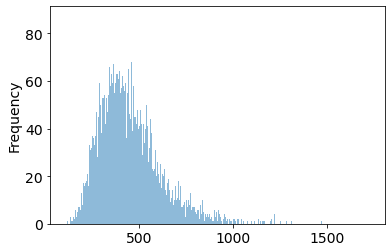

In [12]:
ax = df['len'].plot.hist(bins=max(df['len'])-min(df['len'])+1, alpha=0.5)

<AxesSubplot:xlabel='len', ylabel='explored_states'>

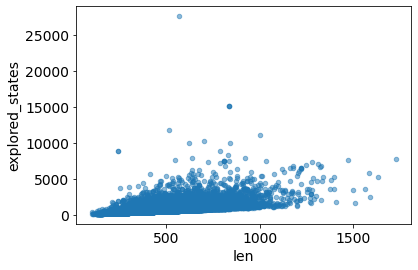

In [13]:
df.plot.scatter(x='len', y='explored_states', alpha=0.5)

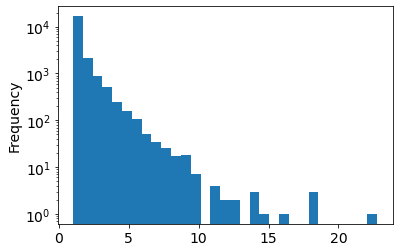

In [14]:
ax = df.loc[df['explored_per_bp'] < 30]['explored_per_bp'].plot.hist(bins=31)
ax.set_yscale('log')

In [16]:
df.loc[df['explored_per_bp'] < 1.0]

,ref,refsize,algo,operation,memory,len,read,spell,cost,start,strand,pushed,popped,repeat_rate,t(map),t(astar),unique_best,explored_states,pushed+popped,lenbin,explored_per_bp
readname,,,,,,,,,,,,,,,,,,,,,


,ref,refsize,algo,operation,memory,len,read,spell,cost,start,strand,pushed,popped,repeat_rate,t(map),t(astar),unique_best,explored_states,crumbs,pushed+popped,explored_per_bp,t(map)_per_bp,crumbs_per_bp,error_rate
0,prefixes/ecoli_head10000000.fa,10610303,astar-seeds,align,0.0,14998,CAGTAATATCATTAATAATTATTTGTGCGCCATATTTACCCAGGCC...,CAGTAATATCATTAATAATTATTTGTGCGCCATATTTACCCAGGCC...,48,4493229,+,7.471330,1.336378,0.0,67.142232,7.317810,1,127224,0,8.807708,8.482731,0.004477,0.0,0.003200
1,prefixes/ecoli_head10000000.fa,10610303,astar-seeds,align,0.0,14988,AGAAAATCCGCAGCAAGCTCATTCAGTCACTGATCTACCCCTGTAT...,AGAAAATCCGCAGCAAGCTCATTCAGTCACTGATCTACCCCTGTAT...,51,3460291,+,22.606752,4.023752,0.0,56.921632,10.864010,1,354621,0,26.630504,23.660328,0.003798,0.0,0.003403
2,prefixes/ecoli_head10000000.fa,10610303,astar-seeds,align,0.0,14998,GCACCTTATGCGCGCGTGCCCCCAGTTTCAGCGCCAGTTCGCGTGC...,GCACCTTATGCGCGCGTGCCCCCAGTTTCAGCGCCAGTTCGCGTGC...,39,465371,+,28.270903,4.502867,0.0,70.770828,17.366705,1,439817,0,32.773770,29.325043,0.004719,0.0,0.002600
3,prefixes/ecoli_head10000000.fa,10610303,astar-seeds,align,0.0,15005,TCATATTCTTCTCCCGAAAAAAAACAGGGCTTGCGCCCTGTTTCTG...,TCATATTCTTCTCCCGAAAAAAAACAGGGCTTGCGCCCTGTTTCTG...,56,1089967,-,7.448517,1.405731,0.0,49.347440,7.184021,1,127132,0,8.854248,8.472642,0.003289,0.0,0.003732
4,prefixes/ecoli_head10000000.fa,10610303,astar-seeds,align,0.0,14991,GACCACGGTCGAAAATGACCTCTCGCTTGCTTAATGGAATACCGGG...,GACCACGGTCGAAAATGACCTCTCGCTTGCTTAATGGAATACCGGG...,41,1188491,+,1.616703,0.293576,0.0,43.333923,4.538016,1,39258,0,1.910279,2.618771,0.002891,0.0,0.002735
5,prefixes/ecoli_head10000000.fa,10610303,astar-seeds,align,0.0,15003,GGCCTGTTTCGCGGCGGCACGGGCTTTTTCTACCGTGGCATTAACC...,GGCCTGTTTCGCGGCGGCACGGGCTTTTTCTACCGTGGCATTAACC...,47,4303710,+,6.626075,1.153436,0.0,64.361060,11.546722,1,114509,0,7.779511,7.632407,0.004290,0.0,0.003133
6,prefixes/ecoli_head10000000.fa,10610303,astarix-seeds_wo_match_pos,align,0.0,14998,CAGTAATATCATTAATAATTATTTGTGCGCCATATTTACCCAGGCC...,CAGTAATATCATTAATAATTATTTGTGCGCCATATTTACCCAGGCC...,48,4493229,+,62.346846,15.722030,0.0,74.309457,21.064663,1,950252,0,78.068876,63.358581,0.004955,0.0,0.003200
7,prefixes/ecoli_head10000000.fa,10610303,astarix-seeds_wo_match_pos,align,0.0,14988,AGAAAATCCGCAGCAAGCTCATTCAGTCACTGATCTACCCCTGTAT...,AGAAAATCCGCAGCAAGCTCATTCAGTCACTGATCTACCCCTGTAT...,51,3460291,+,72.784361,17.515612,0.0,72.986402,22.109393,1,1106639,0,90.299973,73.835001,0.004870,0.0,0.003403
8,prefixes/ecoli_head10000000.fa,10610303,astarix-seeds_wo_match_pos,align,0.0,14998,GCACCTTATGCGCGCGTGCCCCCAGTTTCAGCGCCAGTTCGCGTGC...,GCACCTTATGCGCGCGTGCCCCCAGTTTCAGCGCCAGTTCGCGTGC...,39,465371,+,67.254634,14.043472,0.0,77.024273,19.376200,1,1024401,0,81.298106,68.302507,0.005136,0.0,0.002600
9,prefixes/ecoli_head10000000.fa,10610303,astarix-seeds_wo_match_pos,align,0.0,15005,TCATATTCTTCTCCCGAAAAAAAACAGGGCTTGCGCCCTGTTTCTG...,TCATATTCTTCTCCCGAAAAAAAACAGGGCTTGCGCCCTGTTTCTG...,56,1089967,-,72.259114,18.783339,0.0,77.892322,24.726411,1,1099608,0,91.042453,73.282772,0.005191,0.0,0.003732


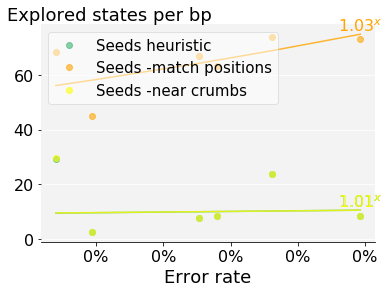

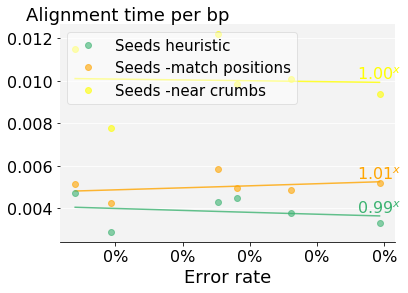

In [13]:
experiment_name = 'ablation'
plots_dir = Path('plots')

df = read_astarix_performance('results_ablation/astarix-seeds/ecoli_head10000000_N200_m15000_hifi/out/alignments.tsv')
df = df.append(read_astarix_performance('results_ablation/astarix-seeds_wo_match_pos/ecoli_head10000000_N200_m15000_hifi/out/alignments.tsv', algo='astarix-seeds_wo_match_pos'), ignore_index=True)
df = df.append(read_astarix_performance('results_ablation/astarix-seeds_wo_skip_near_crumbs_pos/ecoli_head10000000_N200_m15000_hifi/out/alignments.tsv', algo='astarix-seeds_wo_skip_near_crumbs_pos'), ignore_index=True)

display(df)

# error rate
astar_vs_dijkstra_img(df,  y='explored_per_bp', x='error_rate', hline=False, ylog=False, prefix=experiment_name)
astar_vs_dijkstra_img(df, y='t(map)_per_bp', x='error_rate', hline=False, ylog=False, prefix=experiment_name)

,ref,refsize,algo,operation,memory,len,read,spell,cost,start,strand,pushed,popped,repeat_rate,t(map),t(astar),unique_best,explored_states,crumbs,pushed+popped,explored_per_bp,t(map)_per_bp,crumbs_per_bp,error_rate
readname,,,,,,,,,,,,,,,,,,,,,,,,
Created-100000,graphs/MHC1_head0.gfa,28026998,astar-seeds,align,0.0,200,GCCGGAGTAATAGTTTGCGGGCAAGGGGATGTTGGAGAGCACACAC...,GCCGGAGTAATaGTTTgCGGGCAAGgGGATGTTGGAGAGCACACAC...,3,638157,-,0.950,0.130,0.0,0.033633,0.000140,1,373,0,1.080,1.865,0.000168,0.0,0.015
Created-99999,graphs/MHC1_head0.gfa,28026998,astar-seeds,align,0.0,200,CATCTTGTTGAATTGATCCCTTTAACAATATATATTGGCCTTCTTT...,CaTCTTGTTGAATTGATCCCTTTAaCAaTATaTAtTGGCCTTCTTT...,5,4141791,-,3.255,0.405,0.0,0.002667,0.000482,1,839,0,3.660,4.195,0.000013,0.0,0.025
Created-99998,graphs/MHC1_head0.gfa,28026998,astar-seeds,align,0.0,200,CCCTTCATTTGACCATGACTGACAGTTTAAATTGCTCTAGGTATAG...,CcCTTCATTTGACcATGACTGaCAGTTTAAATTGCTCTAGGTATAG...,3,3695730,-,1.430,0.190,0.0,0.000942,0.000199,1,466,0,1.620,2.330,0.000005,0.0,0.015
Created-99997,graphs/MHC1_head0.gfa,28026998,astar-seeds,align,0.0,200,ATGATATACACGAAAGTGTATAGGGAAACGCAAAGCAATCTGAATA...,ATgATATACAcGAAAGtgtATaGGGAAAcGcAAAGCAATCTGAATA...,8,3790574,+,16.630,2.250,0.0,0.005434,0.002158,1,3502,0,18.880,17.510,0.000027,0.0,0.040
Created-99996,graphs/MHC1_head0.gfa,28026998,astar-seeds,align,0.0,200,CTGCACACAACCTGAGGAGAGTAGGAAGAGCACTGGATTTAAAGCC...,CTGcAcACAACCTgAGGAGAGTAGGAAGAGCACTGGATTTAAAGCC...,4,2760824,-,2.970,0.370,0.0,0.001365,0.000390,1,770,0,3.340,3.850,0.000007,0.0,0.020
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Created-55341,graphs/MHC1_head0.gfa,28026998,astar-seeds,align,0.0,200,CAGAATGGCAAACAAAGAAAAACGGAAAATCATCTCTTAGTTCTAC...,CAGAATGGcaAACAaAGAAaAACgGAaAATCATCTCTTAGTTCTAC...,7,190674,+,4.770,0.575,0.0,0.004618,0.000743,1,1134,0,5.345,5.670,0.000023,0.0,0.035
Created-55340,graphs/MHC1_head0.gfa,28026998,astar-seeds,align,0.0,200,CCTCCAAAAGTGCTGGGATTCCAGGCGTGAGCCACCGCACCAGACC...,CCTCCAAAAGTGCTGGGATTcCAGGCGTGAGCCACCGCACCAGACC...,1,4132562,-,0.875,0.115,0.0,0.001030,0.000139,1,353,0,0.990,1.765,0.000005,0.0,0.005
Created-55339,graphs/MHC1_head0.gfa,28026998,astar-seeds,align,0.0,200,GTACGGCTGAGCCCTCACCTGCGTCTCATCTTAATCTTGGTCCTCC...,GTACGGCTGAGCCCTCACCTGCGTCTCATCtTAATCTTGGTCCTCC...,2,4721743,+,0.960,0.195,0.0,0.001118,0.000153,1,365,0,1.155,1.825,0.000006,0.0,0.010


cost
0     0.008876
1     0.056488
2     0.141543
3     0.307460
4     0.437196
5     0.561683
6     0.638095
7     0.690363
8     0.731956
9     0.805618
10    0.962430
11    1.222735
12    1.377817
13    1.597426
14    1.825183
Name: t(map)_per_bp, dtype: float64

cost
0     0.008876
1     0.047612
2     0.085056
3     0.165917
4     0.129737
5     0.124486
6     0.076412
7     0.052267
8     0.041593
9     0.073662
10    0.156811
11    0.260305
12    0.155082
13    0.219609
14    0.227758
Name: t(map)_per_bp, dtype: float64

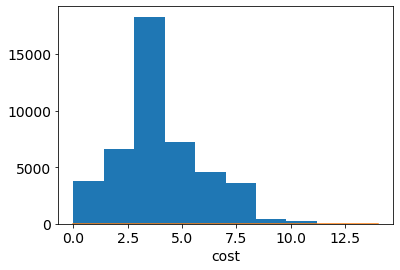

In [48]:
df_seeds = read_astarix_performance('results/astarix-seeds-illumina/MHC1_head100000000_N100000_m200_illumina_errors-1/out/alignments.tsv')
#df_seeds = read_astarix_performance('results/astarix-seeds-illumina/MHC1_head100000000_N100000_m200_illumina_errors-1/out/alignments.tsv')
display(df_seeds)

df_seeds.cost.hist()

x = df_seeds.groupby('cost')['t(map)_per_bp'].sum()
y = x.cumsum()
display(x.cumsum())
z = y/y.max()
display(x)
z.plot.line(z, 'index', drawstyle='steps')

#df_seeds.hist(column='cost')
import numpy as np
import seaborn as sns

#x = np.random.randn(200)
#kwargs = {'cumulative': True}
#sns.distplot(x, hist_kws=kwargs, kde_kws=kwargs)

In [13]:
import seaborn as sns
penguins = sns.load_dataset("penguins")
sns.ecdfplot(data=penguins, x="flipper_length_mm")

AttributeError: module 'seaborn' has no attribute 'ecdfplot'